## Table Of Contents:


### [Import Libraries](#Imports)

### [Read in the previously collected data](#Read-in-the-data)

### [Prepping the data using transformer pipelines](#Data-prep)

### [Possible Evaluation Metrics](#Evaluation-metrics)

### [Baseline Models](#Baseline-model-creation)

### [Tuning Models](#Tuning-the-models)

### [Predict On Testing Data](#Making-predictions)

### Imports

In [63]:
# Data Analysis
import numpy as np
import pandas as pd
import datetime

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor

# Filter warnings
import warnings
warnings.filterwarnings('ignore')

### Read in the data

Here I will read in the train and test sets that I exported after completing the EDA. 

*NOTE: These files don't have any of the features that I engineered or created in the EDA. I will create a pipeline here to handle those transformations*

In [2]:
# Import train and test sets
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')


In [3]:
# Check train set
df_train.head(3)

,season,team,name,birthday,age,nationality,height,weight,number,rookie,...,goals,pim,shots,shot_perc,games,hits,blocked,plusminus,shifts,points
0,20082009,New Jersey Devils,Travis Zajac,1985-05-13,35,CAN,"6' 2""",185,19,False,...,20,29,185,10.81,82,59,40,33,1895,62
1,20082009,New York Islanders,Johnny Boychuk,1984-01-19,36,CAN,"6' 2""",227,55,False,...,0,0,0,0.00,1,3,1,0,20,0
2,20082009,New York Islanders,Andrew Ladd,1985-12-12,34,CAN,"6' 3""",192,16,False,...,15,28,195,7.69,82,117,22,26,1803,49


In [4]:
# Check test set
df_test.head(3)

,season,team,name,birthday,age,nationality,height,weight,number,rookie,...,goals,pim,shots,shot_perc,games,hits,blocked,plusminus,shifts,points
0,20182019,New Jersey Devils,Travis Zajac,1985-05-13,35,CAN,"6' 2""",185,19,False,...,19,20,120,15.83,80,66,38,-25,1818,46
1,20182019,New Jersey Devils,P.K. Subban,1989-05-13,31,CAN,"6' 0""",210,76,False,...,9,60,168,5.36,63,56,75,5,1731,31
2,20182019,New Jersey Devils,Kyle Palmieri,1991-02-01,29,USA,"5' 11""",185,21,False,...,27,42,224,12.05,74,98,35,-9,1580,50


In [5]:
# Split X and Y variables for train set
y_train = df_train['points']
X_train = df_train.drop(['goals', 'assists', 'points'], axis=1)
X_train



,season,team,name,birthday,age,nationality,height,weight,number,rookie,...,sh_toi,ev_toi,pim,shots,shot_perc,games,hits,blocked,plusminus,shifts
0,20082009,New Jersey Devils,Travis Zajac,1985-05-13,35,CAN,"6' 2""",185,19,False,...,164:13,1096:38,29,185,10.81,82,59,40,33,1895
1,20082009,New York Islanders,Johnny Boychuk,1984-01-19,36,CAN,"6' 2""",227,55,False,...,00:34,13:26,0,0,0.00,1,3,1,0,20
2,20082009,New York Islanders,Andrew Ladd,1985-12-12,34,CAN,"6' 3""",192,16,False,...,78:38,1071:35,28,195,7.69,82,117,22,26,1803
3,20082009,New York Islanders,Andy Greene,1982-10-30,37,USA,"5' 11""",190,4,False,...,09:04,704:28,22,38,5.26,49,37,63,3,993
4,20082009,New York Islanders,Cal Clutterbuck,1987-11-18,32,CAN,"5' 11""",216,15,False,...,60:36,922:20,76,136,8.09,78,356,39,-5,1603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2928,20172018,Vegas Golden Knights,William Carrier,1994-12-20,25,CAN,"6' 2""",218,28,False,...,00:39,322:38,19,52,1.92,37,113,10,-3,455
2929,20172018,Vegas Golden Knights,Tomas Nosek,1992-09-01,28,CZE,"6' 2""",205,92,False,...,101:30,634:22,14,92,7.61,67,53,24,6,1004
2930,20172018,Vegas Golden Knights,Alex Tuch,1996-05-10,24,USA,"6' 4""",220,89,False,...,03:30,1004:16,27,171,8.77,78,99,42,3,1366
2931,20172018,Vegas Golden Knights,Nicolas Roy,1997-02-05,23,CAN,"6' 4""",200,10,True,...,00:00,10:46,0,1,0.00,1,2,0,-1,16


In [6]:
# Split X and Y variables for test set
y_test = df_test['points']
X_test = df_test.drop(['points', 'goals', 'assists'], axis=1)
X_test

,season,team,name,birthday,age,nationality,height,weight,number,rookie,...,sh_toi,ev_toi,pim,shots,shot_perc,games,hits,blocked,plusminus,shifts
0,20182019,New Jersey Devils,Travis Zajac,1985-05-13,35,CAN,"6' 2""",185,19,False,...,217:29,1112:40,20,120,15.83,80,66,38,-25,1818
1,20182019,New Jersey Devils,P.K. Subban,1989-05-13,31,CAN,"6' 0""",210,76,False,...,98:27,1166:17,60,168,5.36,63,56,75,5,1731
2,20182019,New Jersey Devils,Kyle Palmieri,1991-02-01,29,USA,"5' 11""",185,21,False,...,21:46,1077:44,42,224,12.05,74,98,35,-9,1580
3,20182019,New Jersey Devils,Fredrik Claesson,1992-11-24,27,SWE,"6' 1""",196,33,False,...,58:34,579:26,9,44,4.55,37,76,33,3,837
4,20182019,New Jersey Devils,Damon Severson,1994-08-07,26,CAN,"6' 2""",205,28,False,...,122:37,1483:03,58,146,7.53,82,83,87,-27,2155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
674,20182019,Vegas Golden Knights,Shea Theodore,1995-08-03,25,CAN,"6' 2""",195,27,False,...,13:21,1383:22,20,202,5.94,79,27,91,-4,1938
675,20182019,Vegas Golden Knights,William Carrier,1994-12-20,25,CAN,"6' 2""",218,28,False,...,00:06,533:29,29,85,9.41,54,277,13,-4,700
676,20182019,Vegas Golden Knights,Tomas Nosek,1992-09-01,28,CZE,"6' 2""",205,92,False,...,116:08,704:55,18,116,6.90,68,75,23,-10,1055
677,20182019,Vegas Golden Knights,Alex Tuch,1996-05-10,24,USA,"6' 4""",220,89,False,...,00:27,1052:49,8,180,11.11,74,92,40,13,1344


### Data prep

In this section I will create some pipelines through which we will be able to pass our data and have it automatically prepared to be fed into a machine learning model. I'll do this with the help of [this tutorial.](https://towardsdatascience.com/custom-transformers-and-ml-data-pipelines-with-python-20ea2a7adb65)

The transformations that I had done in the initial cleaning steps (and that I'll need to work into the below pipelines) are:

<del>    1) Create a feature that returns the players age at the start of a season </del>
    
<del>    2) Transform the height feature into inches </del>
    
<del>     3) Clean up the time on ice metrics to represent seconds instead of MM:ss </del>
    
<del>    4) Create a feature: Presence of letter (Yes/No) </del>
    
<del>    5) Create a feature: Division </del>
    
<del>    6) Create a feature: Conference </del>
    
<del>    7) Create a feature: Birth Month </del>
    
<del>    8) Create a feature: Birth Season </del>
    
<del>    9) Impute any missing numeric values with the median for that column </del>
    
All of the explanations of the code and what each line does for these transformations are in the Cleaning & EDA workbook. I tried to put the comments in here as well, but it ended up being too messy.

In [7]:
# Initialise data dictionaries for below classes
team_info = {'New Jersey Devils':{'Conference':'Eastern','Division':'Metropolitan'},
             'New York Islanders':{'Conference':'Eastern', 'Division':'Metropolitan'},
             'New York Rangers':{'Conference':'Eastern', 'Division':'Metropolitan'},
             'Philadelphia Flyers':{'Conference':'Eastern', 'Division':'Metropolitan'}, 
             'Pittsburgh Penguins':{'Conference':'Eastern', 'Division':'Metropolitan'},
             'Boston Bruins':{'Conference':'Eastern', 'Division':'Atlantic'},
             'Buffalo Sabres':{'Conference':'Eastern', 'Division':'Atlantic'},
             'Montréal Canadiens':{'Conference':'Eastern', 'Division':'Atlantic'}, 
             'Ottawa Senators':{'Conference':'Eastern', 'Division':'Atlantic'},
             'Toronto Maple Leafs':{'Conference':'Eastern', 'Division':'Atlantic'},
             'Carolina Hurricanes':{'Conference':'Eastern', 'Division':'Metropolitan'},
             'Florida Panthers':{'Conference':'Eastern', 'Division':'Atlantic'},
             'Tampa Bay Lightning':{'Conference':'Eastern', 'Division':'Atlantic'},
             'Washington Capitals':{'Conference':'Eastern', 'Division':'Metropolitan'},
             'Chicago Blackhawks':{'Conference':'Western', 'Division':'Central'},
             'Detroit Red Wings':{'Conference':'Eastern', 'Division':'Atlantic'},
             'Nashville Predators':{'Conference':'Western', 'Division':'Central'},
             'St. Louis Blues':{'Conference':'Western', 'Division':'Central'},
             'Calgary Flames':{'Conference':'Western', 'Division':'Pacific'},
             'Edmonton Oilers':{'Conference':'Western', 'Division':'Pacific'},
             'Vancouver Canucks':{'Conference':'Western', 'Division':'Pacific'},
             'Anaheim Ducks':{'Conference':'Western', 'Division':'Pacific'},
             'Dallas Stars':{'Conference':'Western', 'Division':'Central'},
             'Los Angeles Kings':{'Conference':'Western', 'Division':'Pacific'},
             'San Jose Sharks':{'Conference':'Western', 'Division':'Pacific'},
             'Columbus Blue Jackets':{'Conference':'Eastern', 'Division':'Metropolitan'},
             'Minnesota Wild':{'Conference':'Western', 'Division':'Central'},
             'Winnipeg Jets':{'Conference':'Western', 'Division':'Central'},
             'Arizona Coyotes':{'Conference':'Western', 'Division':'Pacific'},
             'Vegas Golden Knights':{'Conference':'Western', 'Division':'Pacific'},
             'Colorado Avalanche':{'Conference':'Western', 'Division':'Central'}}

birth_seasons = {'Jan':'Winter' , 'Feb':'Winter', 'Mar':'Spring', 'Apr':'Spring', 
                   'May':'Spring', 'Jun':'Summer', 'Jul':'Summer', 'Aug':'Summer', 
                   'Sep':'Fall', 'Oct':'Fall', 'Nov':'Fall', 'Dec':'Winter'}


In [8]:
#Custom Transformer that extracts columns passed as argument to its constructor (init function)
class FeatureSelector(BaseEstimator, TransformerMixin):
    
    # Initialise function
    def __init__( self, feature_names ):
        self._feature_names = feature_names 
    
    # Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self
    
    # Return dataframe with selected features
    def transform(self, X, y=None):
        return X[self._feature_names]

    
# Custom Transformer to create and deal with categorical features in the dataset
class CategoricalTransformer(BaseEstimator, TransformerMixin):
    
    # Initialise function with parameters and data dictionaries for calculations
    def __init__(self, conference=True, division=True, birth_month=True, birth_season=True, letter=True, 
                 team_info = team_info, birth_seasons=birth_seasons):
        self._conference = conference
        self._division = division
        self._birth_month = birth_month
        self._birth_season = birth_season
        self._letter = letter
     
    # Do nothing, only return self
    def fit(self, X, y=None):
        return self
    
    # Custom transformations
    def transform(self, X, y=None):
        
        # Conference
        if self._conference:
            X.loc[:,'conference'] = X['team'].apply(lambda x: team_info[x]['Conference'])
        
        # Division
        if self._division:
            X.loc[:,'division'] = X['team'].apply(lambda x: team_info[x]['Division'])
            
        # Birth Month & Season
        if (self._birth_month) and (self._birth_season):
            X.loc[:, 'birth_month'] = X['birthday'].apply(
                lambda x: datetime.datetime.strftime(pd.to_datetime(x), '%b')) 
            X.loc[:, 'birth_season'] = X['birth_month'].apply(lambda x: birth_seasons[x])
        
        elif self._birth_month:
            X.loc[:, 'birth_month'] = X['birthday'].apply(
                lambda x: datetime.datetime.strftime(pd.to_datetime(x), '%b'))
        
        elif self._birth_season:
            X.loc[:, 'birth_season'] = X['birthday'].apply(
                lambda x: birth_seasons[datetime.datetime.strftime(pd.to_datetime(x), '%b')])
        
        # Letter
        if self._letter:
            X.loc[:, 'letter'] = X['captain'].apply(lambda x: 'Yes' if x==True else 'No')
            X['letter'] = X[X['letter'] == 'No']['alternate_capt'].apply(lambda x: 'Yes' if x==True else 'No' )
            X['letter'].fillna('Yes', inplace=True)
         
        # Drop redundant columns
        X = X.drop(['birthday', 'team', 'captain', 'alternate_capt'], axis=1)
            
        # Return transformed dataframe
        return X
    
     
class NumericTransformer(BaseEstimator, TransformerMixin):
    
   # Initialise function with parameters
    def __init__(self, age=True, height=True, total_toi=True, ev_toi=True, pp_toi=True, sh_toi=True):
        self._age = age
        self._height = height
        self._total_toi = total_toi
        self._ev_toi = ev_toi
        self._pp_toi = pp_toi
        self._sh_toi = sh_toi

    # Do nothing, only return self
    def fit(self, X, y=None):
        return self
    
    # Custom transformations
    def transform(self, X, y=None):
        
        if self._age:
            X['season_start'] = X['season'].apply(lambda x: pd.to_datetime(f"{str(x)[:4]}-10-01"))
            X['birthday'] = X['birthday'].apply(lambda x: pd.to_datetime(str(x)))
            X['age_season_start'] = round((X['season_start'] - X['birthday']).dt.days/365).astype(int)

        if self._height:
            X['inches'] = X['height'].apply(lambda x: (int(x[0])*12) + int(x.split(' ')[1].replace('"','')))

        if self._total_toi:
            X['toi_secs'] = X['toi'].apply(lambda x: int(x.split(':')[0])*60 + int(x.split(':')[1]))

        if self._ev_toi:
            X['ev_toi_secs'] = X['ev_toi'].apply(lambda x: int(x.split(':')[0])*60 + int(x.split(':')[1]))
        
        if self._pp_toi:
            X['pp_toi_secs'] = X['pp_toi'].apply(lambda x: int(x.split(':')[0])*60 + int(x.split(':')[1]))

        if self._sh_toi:
            X['sh_toi_secs'] = X['sh_toi'].apply(lambda x: int(x.split(':')[0])*60 + int(x.split(':')[1]))

        # Drop redundant columns
        X = X.drop(['season', 'birthday','season_start', 'height', 'toi', 'pp_toi', 'sh_toi' ,'ev_toi'], axis=1)
        
        # Return transformed dataframe
        return X
    

In [9]:
# Declare categorical features from data, and what ones are needed for the categorical pipeline
categorical_features = ['team', 'birthday', 'nationality', 'rookie', 'position_code',
                       'position_type', 'captain', 'alternate_capt', 'handedness']

# Declare numeric features from data, and what ones are needed for the categorical pipeline
numeric_features = ['height', 'season', 'birthday','weight', 'toi', 'pp_toi', 'sh_toi', 'ev_toi','pim', 
                    'shots', 'shot_perc', 'games', 'hits', 'blocked', 'plusminus', 'shifts']

# Create the seperate pipeline steps
categorical_pipe = Pipeline(steps= [
    ('cat_selector', FeatureSelector(categorical_features)),
    ('cat_transformer', CategoricalTransformer()),
    ('one_hot_encode', OneHotEncoder(sparse=False))
])
    
numerical_pipe = Pipeline(steps = [
    ('num_selector', FeatureSelector(numeric_features)),
    ('num_transformer', NumericTransformer()),
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

# Combine pipelines together
full_pipeline = FeatureUnion(transformer_list= [
    ('cat_pipeline', categorical_pipe),
    ('num_pipeline', numerical_pipe)])

**NOTE:** Up to this point, we have created a full pipeline which will go through sequentially and first transform our categorical features and then pass the result to the numeric pipeline. When we call fit_transform on the full pipeline below and pass in our training data, we will receive back an array of features that has been fit to the training data. It's important to remember that we have dropped some columns in each pipeline, and these features are therefore not included in the resulting data, and then are also NOT being used in the models predictions. The columns that made it all the way through the pipeline and are being used in the first iteration of our predictions are:

['nationality', 'rookie', 'position_code', 'position_type', 'handedness', 'conference', 'division', 'birth_month', 'birth_season', 'letter','weight','pim', 'shots', 'shot_perc', 'games', 'hits', 'blocked', 'plusminus', 'shifts', 'age_season_start', 'inches', 'toi_secs', 'ev_toi_secs','pp_toi_secs', 'sh_toi_secs']

In [10]:
# Fit the pipeline on training data and transform it
X_train_prep = full_pipeline.fit_transform(X_train)


### Evaluation metrics

For a regression problem there are a few key metrics that can be used to evaluate the performance of a model.

**Mean Absolute Error (MAE):** This metric is the most easily interpretable. It's calculated by first finding the residual (error) for each data point and taking the absolute value so that the positive and negative residuals don't cancel out. We then sum up all the residuals and divide by the number of data points. In short, this measure basically tells us the average error we can expect.

Since we are using the absolute value of the residuals, the MAE doesn't indicate any over or underperformance - each residual contributes linearly to MAE. A lower MAE means the model is better at predicting. Typically using the absolute value of the residuals is not as desirable as squaring them - which gives more weight to larger errors.


**Mean Squared Error (MSE):** This metric is very similar to MAE, except instead of using the absolute value of the residuals we square it instead. The result of squaring the residuals is that we put greater weight on any outliers (those data points with larger errors). Put another way, the model is penalised more heavily for predictions that are way off.

**Root Mean Squared Error (RMSE):** This is (as the name suggests) the square root of the MSE. Since the MSE is squared, the units output doesn't match the input units. So in this case, we can't interpret the MSE as "points". Taking the root of the MSE brings us back to similar units, making it easier to interpret.

**Decision & Rationale:** For this analysis the appropriate evaluation metric will be the *ROOT MEAN SQUARED ERROR (RMSE)*. I chose this model as it does take into affect outliers. Since in hockey some players have very great years whereas others have very poor years, and this is sometimes dependent on luck, or just pure skill, these outliers are a key piece to the dataset and I don't want to downplay their significance by using MAE.

### Baseline model creation

Now that we have a pipeline which can transform incoming data in the exact same way everytime, AND that pipeline has been FIT TO THE TRAINING DATA, we can move forward and try out some different models. 

It's important now that I do not fit the pipeline to any testing data, we will use the already fit pipeline and then on any incoming data only use the "TRANSFORM" method to transform the data.

The process for this initial model building step will not include any hyperparameter tuning, it will just be to get an idea of what sort of performance I should try to improve upon moving forward. Each step will involve:

    1) Create an instance of the SKLearn model

    2) Fit the model using a 5-fold cross validation and use the average MSE as the scoring metric
    

[**Linear Regression:**](#Linear-Regression) Average RMSE across 5-fold cross validation: 6.59 points

[**Lasso Regression:**](#Lasso-Regression) Average RMSE across 5-fold cross validation: 7.41 points

[**Support Vector Regression:**](#SVM-Regression) Average RMSE across 5-fold cross validation: 6.76 points

[**Decision Tree Regression:**](#Decision-Tree-Regression) Average RMSE across 5-fold cross validation: 8.81 points

[**Random Forest Regression:**](#Random-Forest-Regression) Average RMSE across 5-fold cross validation: 6.37 points

[**Voting Regressor:**](#Voting-Regressor) Average RMSE across 5-fold cross validation: 6.14 points


I would expect the 2 ensemble methods (random forest and voting) to perform a bit better than each other model on it's on, since these take into account the vote from more than 1 model.

Moving forward, since performance tends to be quite similar between most of the models, I will go ahead and try and tune some hyperparameters for all of these except the Decision Tree Regressor. This is because the Random Forest will perform better so it makes the most sense to work with that one instead.

In [54]:
# Create a dataframe of baseline model performance
d = {'Linear Regression': lr_rmse,
     'Lasso Regression': lasso_rmse,
     'Support Vector Machine': svm_rmse,
     'Decision Tree':dtr_rmse,
     'Random Forest':rfr_rmse,
     'Voting Regression':voting_rmse}

results_df = pd.DataFrame(d.items(), columns=['Model', 'Untuned Performance (RMSE)'])
results_df

,Model,Untuned Performance (RMSE)
0,Linear Regression,6.59
1,Lasso Regression,7.41
2,Support Vector Machine,6.76
3,Decision Tree,8.81
4,Random Forest,6.37
5,Voting Regression,6.14


##### Linear Regression

In [11]:
# Create instance of model
lr = LinearRegression()

# Fit baseline model using training data
cvs = cross_val_score(lr, X_train_prep, y_train, cv=5, scoring = 'neg_mean_squared_error')
lr_rmse = round(np.sqrt(cvs.mean()*-1),2)

# Print metrics for regressor
print('-'*10)
print('Average RMSE across 5-fold cross validation:',lr_rmse)
print('-'*10)

----------
Average RMSE across 5-fold cross validation: 6.59
----------


##### Lasso Regression

In [12]:
# Create instance of model
lasso_r = Lasso(random_state=4)

# Fit baseline model using training data
cvs = cross_val_score(lasso_r, X_train_prep, y_train, cv=5, scoring = 'neg_mean_squared_error')
lasso_rmse = round(np.sqrt(cvs.mean()*-1),2)

# Print metrics for regressor
print('-'*10)
print('Average RMSE across 5-fold cross validation:',lasso_rmse)
print('-'*10)

----------
Average RMSE across 5-fold cross validation: 7.41
----------


##### SVM Regression

In [13]:
# Create instance of model
svr = SVR()

# Fit baseline model using training data
cvs = cross_val_score(svr, X_train_prep, y_train, cv=5, scoring = 'neg_mean_squared_error')
svm_rmse = round(np.sqrt(cvs.mean()*-1),2)

# Print metrics for regressor
print('-'*10)
print('Average RMSE across 5-fold cross validation:',svm_rmse)
print('-'*10)

----------
Average RMSE across 5-fold cross validation: 6.76
----------


##### Decision Tree Regression

In [14]:
# Create instance of model
dtr = DecisionTreeRegressor(random_state=4)

# Fit baseline model using training data
cvs = cross_val_score(dtr, X_train_prep, y_train, cv=5, scoring = 'neg_mean_squared_error')
dtr_rmse = round(np.sqrt(cvs.mean()*-1),2)

# Print metrics for regressor
print('-'*10)
print('Average RMSE across 5-fold cross validation:',dtr_rmse)
print('-'*10)

----------
Average RMSE across 5-fold cross validation: 8.81
----------


##### Random Forest Regression

In [15]:
# Create instance of model
rfr = RandomForestRegressor(random_state=4)

# Fit baseline model using training data
cvs = cross_val_score(rfr, X_train_prep, y_train, cv=5, scoring = 'neg_mean_squared_error')
rfr_rmse = round(np.sqrt(cvs.mean()*-1),2)

# Print metrics for regressor
print('-'*10)
print('Average RMSE across 5-fold cross validation:',rfr_rmse)
print('-'*10)

----------
Average RMSE across 5-fold cross validation: 6.37
----------


##### Voting Regressor

In [16]:
# Create instance of model
voting_r = VotingRegressor([('lr',lr), ('lasso_r',lasso_r), ('svr',svr),('dtr',dtr),('rfr',rfr)])

# Fit baseline model using training data
cvs = cross_val_score(voting_r, X_train_prep, y_train, cv=5, scoring = 'neg_mean_squared_error')
voting_rmse = round(np.sqrt(cvs.mean()*-1),2)

# Print metrics for regressor
print('-'*10)
print('Average RMSE across 5-fold cross validation:',voting_rmse)
print('-'*10)

----------
Average RMSE across 5-fold cross validation: 6.14
----------


### Tuning the models

Now that we have some baseline models, I can try to improve upon their performance via hyperparameter tuning. The one thing I'll just have to keep an eye out for will be overfitting, which is why it will be important to test these tuned models out using unseen data.

The process here will be the same for each model and will include:

    1) Setting up a parameter grid with different combinations for each hyperparameter

    2) Create an instance of the SKLearn model

    3) Perform the GridSearch using 5-fold cross validation to find the best combination of hyperparameter values
    
    4) Fit the grid to our training data
    
    5) Create a new regressor object which is a SKLearn instance of the initial object, and the best combination of parameters found via GridSearch
    

[**Linear Regression:**](#Tuned-Linear-Regression) RMSE for best estimator: 6.59 points. It makes sense this didn't change at all from the baseline since GridSearch found the best hyperparameter values were the exact same as the default.

[**Lasso Regression:**](#Tuned-Lasso-Regression) RMSE for best estimator: 6.58 points. This is a pretty good improvement from the untuned model above.

[**Support Vector Regression:**](#Tuned-SVM-Regression) RMSE for best estimator: 5.56 points, another pretty good increase.

[**Random Forest Regression:**](#Tuned-Random-Forest-Regression) RMSE for best estimator: 5.92 points

[**Voting Regressor:**](#Tuned-Voting-Regression) RMSE for best estimator: 5.7 points


The best estimator using tuned models was the Support Vector Machine. However since all of the models actually performed pretty well, and to avid overweight any one particular model, I believe that it makes sense to actually go ahead and use the voting regressor which combines all of the tuned models.


In [55]:
# Add tuned performance to results DF
results_df['Tuned Performance (RMSE)'] = [tuned_lr_rmse, tuned_lasso_rmse, tuned_svr_rmse, 'N/A', 
                                         tuned_rfr_rmse, tuned_voting_rmse]

results_df

,Model,Untuned Performance (RMSE),Tuned Performance (RMSE)
0,Linear Regression,6.59,6.59
1,Lasso Regression,7.41,6.58
2,Support Vector Machine,6.76,5.56
3,Decision Tree,8.81,N/A
4,Random Forest,6.37,5.92
5,Voting Regression,6.14,5.7


##### Tuned Linear Regression

In [33]:
# Create a grid of possible parameters
param_grid = {'normalize':[True, False]}

# Initialise model
lr = LinearRegression()

# Perform gridsearchCV
grid = GridSearchCV(lr, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True,
                   refit=True)

# Fit grid to prepared training data
grid.fit(X_train_prep, y_train)

# Calculate RMSE using best score
tuned_lr_rmse = round(np.sqrt(grid.best_score_*-1),2)

# Create tuned regressor using the best estimator found via GridSearch
tuned_lr = grid.best_estimator_


# Print feedback
print('FEEDBACK')
print('-'*10)
print('Default Parameters:', lr.get_params())
print('\n')
print('Best Parameters:',grid.best_params_)
print('\n')
print('RMSE for best estimator:',tuned_lr_rmse)
print('-'*10)



FEEDBACK
----------
Default Parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}


Best Parameters: {'normalize': False}


RMSE for best estimator: 6.59
----------


##### Tuned Lasso Regression

In [34]:
# Create a grid of possible parameters
param_grid = {'alpha':[x/10000 for x in range(1,10000,100)],'normalize':[True, False], 
              'max_iter':[100,200,500, 1000, 1500], 'selection':['cyclic','random']}

# Initialise model
lasso_r = Lasso(random_state=4)

# Perform gridsearchCV
grid = GridSearchCV(lasso_r, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True,
                   refit=True, )

# Fit grid to prepared training data
grid.fit(X_train_prep, y_train)

# Calculate RMSE using best score
tuned_lasso_rmse = round(np.sqrt(grid.best_score_*-1),2)

# Create tuned regressor using the best estimator found via GridSearch
tuned_lasso = grid.best_estimator_


# Print feedback
print('FEEDBACK')
print('-'*10)
print('Default Parameters:', lasso_r.get_params())
print('\n')
print('Best Parameters:',grid.best_params_)
print('\n')
print('RMSE for best estimator:',tuned_lasso_rmse)
print('-'*10)



FEEDBACK
----------
Default Parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'normalize': False, 'positive': False, 'precompute': False, 'random_state': 4, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}


Best Parameters: {'alpha': 0.0001, 'max_iter': 100, 'normalize': True, 'selection': 'random'}


RMSE for best estimator: 6.58
----------


##### Tuned SVM Regression 

Since training this initially took a very long time due to many values for "C" and "tol" I was testing out, I decided to run the regression and plot the results for these parameters to narrow down the possibilities. The best values for tol seemed to be < 1 and the best values for C were somewhere between 5 and 10.

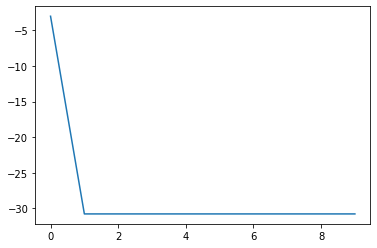

In [27]:
# Loop through different tol values and find best value
tol = []
error = []

for i in range(1,10000,1000):
    tol.append(i/1000)
    svr = SVR(tol=i)
    err = np.mean(cross_val_score(svr, X_train_prep, y_train, scoring = 'neg_median_absolute_error',cv=5))
    error.append(err)
    
plt.plot(tol,error);

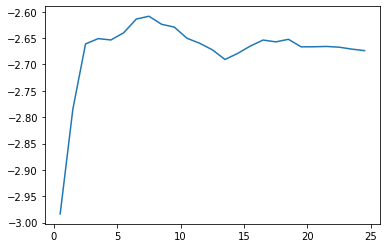

In [28]:
# Plot different values for C to find best one
c = []
error = []

for i in range(1,50,2):
    c.append(i/2)
    svr = SVR(C=i)
    err = np.mean(cross_val_score(svr, X_train_prep, y_train, scoring = 'neg_median_absolute_error',cv=5))
    error.append(err)
    
plt.plot(c,error);

In [43]:
# Create a grid of possible parameters
param_grid = [{'kernel':['linear', 'rbf', 'sigmoid'],'tol':[.0001, .001, .01, .1, 1], 'C': [float(x) for x in range(5,10)]},
             {'kernel':['rbf','poly', 'sigmoid'], 'gamma':['scale','auto'],'tol':[.0001, .001, .01, .1, 1], 'C': [float(x) for x in range(5,10)]},
             {'kernel':['poly'], 'degree':range(1,10,1),'tol':[.0001, .001, .01, .1, 1], 'C':[float(x) for x in range(5,10)]}]

# Initialise model
svr = SVR()

# Perform gridsearchCV
grid = GridSearchCV(svr, param_grid, scoring='neg_mean_squared_error', return_train_score=True,
                   refit=True)

# Fit grid to prepared training data
grid.fit(X_train_prep, y_train)

# Calculate RMSE using best score
tuned_svr_rmse = round(np.sqrt(grid.best_score_*-1),2)

# Create tuned regressor using the best estimator found via GridSearch
tuned_svr = grid.best_estimator_


# Print feedback
print('FEEDBACK')
print('-'*10)
print('Default Parameters:', svr.get_params())
print('\n')
print('Best Parameters:',grid.best_params_)
print('\n')
print('RMSE for best estimator:',tuned_svr_rmse)
print('-'*10)



FEEDBACK
----------
Default Parameters: {'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'auto_deprecated', 'kernel': 'rbf', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}


Best Parameters: {'C': 9.0, 'kernel': 'rbf', 'tol': 1}


RMSE for best estimator: 5.56
----------


##### Tuned Random Forest Regression

In [44]:
# Create a grid of possible parameters
param_grid = {'n_estimators':[50,100,250,500], 'min_samples_split':[2,3,4], 'max_features':['auto','sqrt','log2'],
             'oob_score':[True,False]}

# Initialise model
rfr = RandomForestRegressor(random_state=4)

# Perform gridsearchCV
grid = GridSearchCV(rfr, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True,
                   refit=True)

# Fit grid to prepared training data
grid.fit(X_train_prep, y_train)

# Calculate RMSE using best score
tuned_rfr_rmse = round(np.sqrt(grid.best_score_*-1),2)

# Create tuned regressor using the best estimator found via GridSearch
tuned_rfr = grid.best_estimator_


# Print feedback
print('FEEDBACK')
print('-'*10)
print('Default Parameters:', rfr.get_params())
print('\n')
print('Best Parameters:',grid.best_params_)
print('\n')
print('RMSE for best estimator:',tuned_rfr_rmse)
print('-'*10)



FEEDBACK
----------
Default Parameters: {'bootstrap': True, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 'warn', 'n_jobs': None, 'oob_score': False, 'random_state': 4, 'verbose': 0, 'warm_start': False}


Best Parameters: {'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 500, 'oob_score': True}


RMSE for best estimator: 5.92
----------


##### Tuned Voting Regression

In [45]:
# Create instance of model
tuned_voting = VotingRegressor([('lr',tuned_lr), ('lasso_r',tuned_lasso), ('svr',tuned_svr),('rfr',tuned_rfr)])

# Fit baseline model using training data
cvs = cross_val_score(tuned_voting, X_train_prep, y_train, cv=5, scoring = 'neg_mean_squared_error')
tuned_voting_rmse = round(np.sqrt(cvs.mean()*-1),2)

# Print metrics for regressor
print('-'*10)
print('Average RMSE across 5-fold cross validation:',tuned_voting_rmse)
print('-'*10)

----------
Average RMSE across 5-fold cross validation: 5.7
----------


### Making predictions

Now comes the fun part, seeing how our final model actually performs on our dataset. For this, I'll simply need to transform the testing set by using our previously created pipeline, fit the tuned model of our choice using the training set, and then use that fit model to predict our testing set.

Let's see how we get on!

I correctly predicted 15 of the top 20 players; albeit not in the same order, but I was expecting the order to be off a little bit anyways due to puck-luck or players having career-best seasons out of no where. I would say that there don't seem to be any surprises with my predictions, all of these players are typically somewhere near the top anyways.

In [65]:
# Prepare X test data
X_test_prep = full_pipeline.transform(X_test)

# Fit the tuned voting regressor
tuned_voting.fit(X_train_prep, y_train)

# Predict using the voting regressor
preds = tuned_voting.predict(X_test_prep)

# Calculate RMSE on test set
print('RMSE on the test set:', round(np.sqrt(mean_squared_error(y_test, preds)),2))

RMSE on the test set: 6.74


In [66]:
# Create a dataframe showing actuals vs predictions
pred_df = pd.DataFrame(zip(df_test['name'], y_test, preds), columns = ['Name', 'Actual Points', 'Predicted Points'])

In [69]:
# Show top 20 players based on actual points
pred_df.sort_values(by=['Actual Points'], ascending=False).head(20)

,Name,Actual Points,Predicted Points
277,Nikita Kucherov,128,85.175107
463,Connor McDavid,116,79.689907
313,Patrick Kane,110,84.858211
462,Leon Draisaitl,105,82.198091
111,Brad Marchand,100,70.575897
89,Sidney Crosby,100,77.416678
436,Nathan MacKinnon,99,90.756752
406,Johnny Gaudreau,99,78.606968
270,Steven Stamkos,98,73.384111
257,Aleksander Barkov,96,70.561715


In [70]:
# Show top 20 players based on my predictions
pred_df.sort_values(by='Predicted Points', ascending=False).head(20)

,Name,Actual Points,Predicted Points
436,Nathan MacKinnon,99,90.756752
277,Nikita Kucherov,128,85.175107
313,Patrick Kane,110,84.858211
288,Alex Ovechkin,89,83.935384
462,Leon Draisaitl,105,82.198091
463,Connor McDavid,116,79.689907
406,Johnny Gaudreau,99,78.606968
89,Sidney Crosby,100,77.416678
626,Mark Scheifele,84,77.154997
431,Gabriel Landeskog,75,76.830390


In [75]:
# Proportion of top 20 that I predicted
actual_top_20 = pred_df.sort_values(by=['Actual Points'], ascending=False).head(20)['Name']
pred_top_20 = pred_df.sort_values(by='Predicted Points', ascending=False).head(20)['Name']

In [84]:
# Number of players predicted in top 20, who actually were in top 20
print(len(set(pred_top_20).intersection(set(actual_top_20))))
print('-'*10)

# Players names
print(set(pred_top_20).intersection(set(actual_top_20)))

15
----------
{'Johnny Gaudreau', 'Brad Marchand', 'Patrick Kane', 'Sidney Crosby', 'Mikko Rantanen', 'Claude Giroux', 'Brayden Point', 'Nathan MacKinnon', 'Mark Scheifele', 'Nikita Kucherov', 'Connor McDavid', 'John Tavares', 'Steven Stamkos', 'Alex Ovechkin', 'Leon Draisaitl'}
